# Esercizio 3 - Automatic Summarization

# Testo esercitazione

• a simple extractive algorithm
reduce the document size of e.g., 10%, 20%, 30%

1. individuate the topic of the text being summarised; the topic
can be referred to as a (set of) NASARI vector(s):
v t1 = {term 1 _score, term 2 _score, ..., term 10 _score }
v t2 = {term 1 _score, term 2 _score, ..., term 10 _score }
...

2. create the context, by collecting the vectors of terms herein
(this step can be repeated, by dumping the contribution of the
associated terms at each round);

3. retain paragraphs whose sentences contain the most salient terms, based on the Weighted Overlap, WO(v 1 ,v 2 )
    -rerank paragraphs weight by applying at least one of the mentioned approaches (title, cue, phrase, cohesion).

# Implementazione

- Il task è stato implementato utilizzando il Title Method: a partire dalle parole del titolo si determina il topic del documento.
Per lo sviluppo di un contesto più dettagliato, lo step dell'estrazione del vettore nasari è ripetuto per i termini estratti dal titolo.

- Per ogni paragrafo del testo se ne calcola un valore di rank, in modo da poter determinare quali sono i più salienti al fine del testo riassunto.
Questo valore di rank è calcolato dalla somma del valore del Weighted Overlap tra il vettore nasari di ciascuna parola del paragrafo e ciascuna parola del contesto.

- Il testo riassunto è prodotto ordinando i paragrafi in ordine decrescente di rank, in modo da eliminare quelli con valore minore in un numero che dipende dal compression rate dato in input.
Infine il nuovo documento è prodotto riscrivendo i paragrafi non eliminati nel loro ordine originale.

#Per esecuzione



*   gold-documents -> contiene il gold standard con le parole più importanti con cui confronteremo quelle dei riassunti
*   summarized-words -> conterrà le parole comuni di ogni riassunto
*   original-documents -> conterrà il testo originale
*   text-summarized -> conterrà i riassunti con diversi compression rate
*   utils -> Nasari e stop words


In [ ]:
import pprint
import re
import chardet

pp = pprint.PrettyPrinter(indent=4)
stop_words_list = []

# Ritorna 'nasari', un dict in cui ogni elemento è di questa forma:
# 'parola': {   'b_id': 'bn:00004591n',
#                      'terms': [   {'term1': peso1},
#                                   {'term2': peso2},
#                                    .
#                                    .
#                                    .
#                                   ]}
#
#   - b_id è il babelsynset id
#   - terms contiene una lista di coppie (lemma, weight), ordinata sul weight
# per visualizzare bene nasari utilizzare:
# pp.pprint(nasari)
def get_nasari(file_path):
    nasari = {}

    # Apertura file nasari 
    file = open(file_path, "r", encoding='utf-8')
    for line in file:
        line = line.strip()
        if (line is not None) and (len(line) > 0):
            nasari_fields = line.split(';')
            #BabelsynsetID nel primo campo della riga
            babel_synset_id = nasari_fields[0]
            #Nome pagina wikipedia nel secondo campo
            wikipage_title = nasari_fields[1].lower()

            terms = []
            #Lettura delle coppie <lemma,weight> del vettore
            for lemma_weight in nasari_fields[2:]:

                if len(lemma_weight.split('_')) == 2:
                  #alla posizione 1 mettiamo i lemmi
                    lemma = lemma_weight.split('_')[0]
                    #alla posizione 2 mettiamo i pesi dei rispettivi lemmi
                    weight = float(lemma_weight.split('_')[1])
                    terms.append({lemma: weight})

                #Inserimento dati vettore nel dict
                nasari[wikipage_title] = {
                    'b_id': babel_synset_id,
                    'terms': terms,
                }
    return nasari

#Weighted Overlap
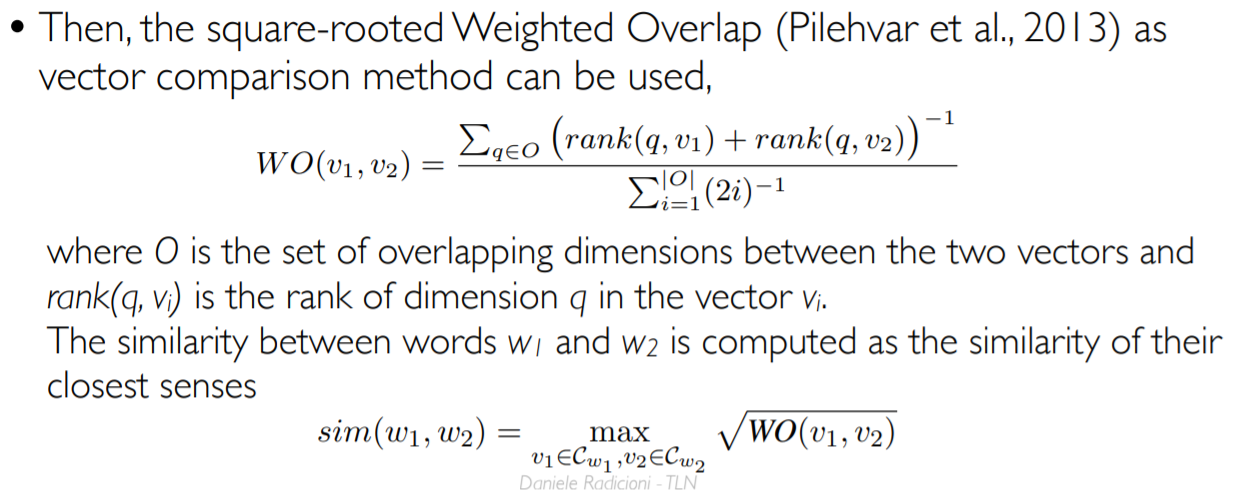

In [ ]:
# Calcola il weighted overlap tra due vettori nasari in input
def weighted_overlap(nasari_vector1, nasari_vector2):
    terms_v1 = set()
    terms_v2 = set()
    
    # POer i terms dei due vettori per il calcolo overlap
    for term in nasari_vector1['terms']:
        terms_v1 = terms_v1.union(term.keys())

    for term in nasari_vector2['terms']:
        terms_v2 = terms_v2.union(term.keys())

    # Insieme degli elementi in comune tra i due vettori
    overlap = set.intersection(terms_v1, terms_v2)

    # calcolo valore weighted_overlap
    wo = 0
    i = 1
    #denominatore della formula sopra
    den = 0
    for word in overlap:
        # il += implementa le sommatorie
        wo += pow(rank(word, nasari_vector1) + rank(word, nasari_vector2), -1)
        den += pow(2 * i, -1)
        i += 1
    #evitiamo divisione per zero
    if den == 0:
        return 0
    else:
        return wo / den


# restituisce l'indice di una parola in un vettore
def rank(word, vector):
    terms = []

    for term in vector['terms']:
        for key in term.keys():
            terms.append(key)

    index = terms.index(word) + 1
    return index



#Rank paragrafi

In [ ]:
# Calcola il valore di rank di ogni paragrafo in base al contesto
#:return: ranks 
def rank_paragraphs(text, context, nasari):
    ranks = []
    position = 0

    #Paragrafi del testo (tranne il primo che è il titolo)
    for paragraph in text[1:]:
        rank = 0
        #Per ogni parola del paragrafo
        for word1 in paragraph.split(' '):
            #Controllo se è presente il vettore della parola in nasari
            if word1 in nasari:
                #Confronto la parola del paragrafo con tutte quelle del contesto usando Weighted Overlap
                for word2 in context:
                    # Rank WO è la somma di tutti i rank
                    rank += weighted_overlap(nasari[word1], nasari[word2])
                    
                    #Se è una parola del titolo aggiungo bonus del 20% perchè è più rilevante
                    if word1 in text[0]:
                        rank += (rank *20/100)
        # Inserimento in una lista della tripla
        # <Posizione paragrafo nel testo, Testo del paragrafo, Valore rank calcolato con WO>
        ranks.append((position, paragraph, rank))
        position+=1
    return ranks

#Funzioni Ausiliarie


*   get_stop_words:  Ritorna una lista con le stop words
*   remove_punctuation: Rimuove i segni di punteggiatura dalla stringa in input
*   get_words_from_title: Ritorna le parole del titolo del testo in input, utili per determinare il topic (Title Method)
*   get_text: Lettura del documento di testo da riassumere
*   get_lemmas_for_word: Data una parola, restituisce le parole contenute nel suo vettore di nasari
*   get_context: Dato un insieme di parole, restituisce le parole contenute nei loro rispettivi vettori di nasari  



In [ ]:
# Ritorna una lista con le stop words
def get_stop_words():
    if len(stop_words_list) == 0:
        f = open("utils/stop_words_FULL.txt", "r")
        for x in f:
            stop_words_list.append(x.replace("\n", ""))

    return stop_words_list

# Rimuove i segni di punteggiatura dalla stringa in input
def remove_punctuation(string):
    chars = '.,:;!?()”“…-’‘#1234567890=£$€^<>_[]{}*–'
    for c in chars:
        string = string.replace(c, '')
    string = string.replace("’s", '')
    return string


# Ritorna le parole del titolo del testo in input (prima riga tel testo), utili per determinare il topic (Title Method)
def get_words_from_title(text):
    stop_words = get_stop_words()

    # Title
    title = []
    for w in str(text[0]).split(" "):
        if remove_punctuation(w.lower()) not in stop_words:
            title.append(remove_punctuation(w.lower()))

    return title

# Lettura del documento di testo da riassumere
def get_text(path):
    lines = []
    f = open(path, "r", encoding='utf-8')
    for l in f:
        if not l.startswith('#') and len(l) > 1:
            lines.append(l.strip())
    return lines

# Data una parola, restituisce le parole contenute nel suo vettore di nasari
def get_lemmas_for_word(word):
    lemmas = set()

    for term in nasari[word]['terms']:
        for lemma in term:
            if lemma in nasari:
                lemmas.add(lemma)

    return lemmas

# Dato un insieme di parole, restituisce le parole contenute nei loro rispettivi vettori nasari
def get_context(words):
    context = set()

    for word in words:
        if word in nasari:
            context = set.union(context, get_lemmas_for_word(word))

    return context

#Produzione testo riassunto

In [ ]:
# Produzione del testo riassunto in base al compression rate e ai paragrafi ordinati in base al rank
def summarize_text(title, ranked_paragraphs, num_words, filename):
    words_count = 0
    i = 0
    ordered_paragraphs = []

    # Creazione file
    f = open("./text-summarized/summary_" + filename, "w")
    # Scrittura titolo
    f.write(title + "\n\n")
    
    # Selezione dei paragrafi in ordine di rank
    # fino al numero necessario di parole (calcolato in base al compression rate)
    while words_count <= num_words:
        #aggiungo ai paragrafi del riassunto i paragrafi della lista in cui sono 
        #ordinati in base al rank
        ordered_paragraphs.append(ranked_paragraphs[i])
        # e controllo di non superare il limite di lunghezza di parole del 
        # riassunto sommando la lunghezza del paragrafo che ho aggiunto
        words_count += len(ranked_paragraphs[i][1])
        i+=1

    # Abbiamo aggiunto i paragrafi in base al rank, ma non in base all'ordine
    # con cui compaiono nel testo originale, quindi dobbiamo
    # ordinarli in base alla loro posizione originale nel testo ricordando che un paragrafo
    # è una tripla
    # <Posizione paragrafo nel testo, Testo del paragrafo, Valore rank calcolato con WO>
    ordered_paragraphs = sorted(ordered_paragraphs, key = lambda x: (x[0]))

    i = 0
    # Scrittura paragrafi in ordine
    for p in ordered_paragraphs:
        # ordered_paragraphs è una lista di tuple fatte così(Posizione,Testo,Rank con WO)
        # quindi ordered_paragraphs[i][1] significa prendere la tupla i-esima e stampare il secondo
        # elemento ossia il testo
        f.write(str(ordered_paragraphs[i][1]) + "\n")
        i+=1

    f.close()

#Evaluation

In [ ]:
def get_ordered_list_words(definizioni):
    common_words = []
    occurrences = []

    for defin in definizioni:
        removed_puntuaction= remove_punctuation(defin)
        for word in removed_puntuaction.split(" "):
                     
            if word not in common_words:
                common_words.append(word)
                occurrences.append(1)
            else:
                occurrences[common_words.index(word)]+=1

    for i in range(0, len(common_words)-1) :
        for j in range(i+1, len(common_words)) :
            if occurrences[i] < occurrences[j] :
                aus = occurrences[i]
                occurrences[i] = occurrences[j]
                occurrences[j] = aus
                aus = common_words[i]
                common_words[i] = common_words[j]
                common_words[j] = aus
    return common_words

"""
Remove all special characters from a given string preserving the spaces
ex. 
a="!£$%& é*§ç°ç-.,;;<>2 345 67gujgf "
will be
éçç234567gujgf
"""
def remove_special_characters(string_to_clean):
    return re.sub(r'[^\w\s]', '', string_to_clean)
    
def get_relevant_words(input_file,output_file):
    
        
        f = open(input_file, "r",  encoding=chardet.detect(open(input_file, 'rb').read())['encoding'])
        lines = []

        for l in f:
            clean_l= remove_special_characters(l)

            if not clean_l.startswith('#') and len(clean_l) > 1:
                lines.append(clean_l.strip())


        ordered_words=[]

        ordered_words = get_ordered_list_words(lines)
        stop_words_list=get_stop_words()

        l3 = [x for x in ordered_words if x.lower() not in stop_words_list]


        out = open(output_file, "w",  encoding="utf8")
        for word in l3:
            out.write(word+"\n")
        return l3
    
    

*   BLUE (bilingual evaluation understudy)
*   ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

In [ ]:
#Precision
def blue_evaluation(gold_standard,summarized_words):
  
  common_words = [x for x in gold_standard if x.lower()  in summarized_words]
  #print(str(len(common_words)))
  precision= len(common_words)/len(summarized_words)
  print("Precision: "+ str(precision))
  return precision

#Recall
def rogue_evaluation(gold_standard,summarized_words):
  common_words = [x for x in gold_standard if x.lower()  in summarized_words]
  recall= len(common_words)/len(gold_standard)
  print("Recall: "+ str( recall))
  return recall



#Dati in input

In [ ]:
##################### File input ##############################

# - Path file 
path_to_original_file = "./original-documents/Andy-Warhol.txt"
nasari_file_path = "./utils/dd-small-nasari-15.txt"

# - Compression Rate
compression_rate = [10]

###############################################################

# Caricamento dei vettori nasari
nasari = get_nasari(nasari_file_path)

# Lettura testo da riassumere
original_file = get_text(path_to_original_file)

# Title method - keyword del titolo per determinare il topic
title_words = get_words_from_title(original_file)
#print("Title words:", title_words)

# topic = title_words
topic = get_context(title_words)
# A partire dalle parole nei vettori del topic, se ne prendono i vettori nasari
context = get_context(topic)
#context2 = get_context(context)
#print(context)

# Rank dei paragrafi, ordinati in ordine decrescente di rank
rank_wo = rank_paragraphs(original_file, context, nasari)
rank_wo = sorted(rank_wo, key = lambda x: x[2], reverse=True)

for rate in compression_rate:
  # Calcolo parole del testo da produrre in base al compression rate
  num_words = len(str(original_file[1:]))
  target_num_words = num_words - num_words * rate / 100.

  # Produzione del testo riassunto
  name_rate="_rate"+str(rate)+".txt"
  # con le seguenti due istruzioni ottengo il nome del file eliminando l'estensione
  name_file = path_to_original_file.split("/")[-1]
  name_file = name_file.split(".")[0]
  summarize_text(original_file[0], rank_wo, target_num_words, name_file+name_rate)

  #creo il gold standard per Andy-Warhol.txt
  gold_standard= get_relevant_words(path_to_original_file,"gold-documents/Andy-Warhol.txt")
  # ottendo le parole comuni nel riassunto
  summarized_words= get_relevant_words("text-summarized/summary_Andy-Warhol"+name_rate,"summarized-words/Andy-Warhol"+name_rate)
  print("Compression Rate: " + str(rate))
  
  blue_evaluation(gold_standard,summarized_words)
  rogue_evaluation(gold_standard,summarized_words)  

Compression Rate: 10
Precision: 0.7985257985257985
Recall: 0.7593457943925234


#Output
Compression Rate: 10

- **Precision:** 0.7923076923076923

- **Recall:** 0.7236533957845434

Compression Rate: 20

- **Precision:** 0.7972222222222223

- **Recall:** 0.6721311475409836

Compression Rate: 30

- **Precision:** 0.7872340425531915

- **Recall:** 0.6065573770491803

Compression Rate: 90

- **Precision:** 0.7857142857142857

- **Recall:** 0.10304449648711944